#### Check that spark is running

In [1]:
import org.apache.spark.sql._
val basedir = "spark-warehouse/prescription"

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4044
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1549978168619)
SparkSession available as 'spark'


import org.apache.spark.sql._
basedir: String = spark-warehouse/prescription


## Let's first compute some basic statistics about the patients

In [21]:
%run src/scala/register_tables.scala

In [22]:
register_tables(spark, "spark-warehouse/")

===Prescription dataset===
registering patients
registering prescriptions
registering drugs
ok!
Use register_elders() instead
register_hospitalization() will later be used to register the hospitalized portion of the elders dataset
===Hospitalization dataset===
registering all
registering patients
registering prescriptions
registering drugs
ok!
===NPR Elders===
ok!
+--------+--------------------------+-----------+
|database|tableName                 |isTemporary|
+--------+--------------------------+-----------+
|        |birthyearcounts           |true       |
|        |drugs                     |true       |
|        |elders                    |true       |
|        |elders_drugs              |true       |
|        |elders_patients           |true       |
|        |elders_prescriptions      |true       |
|        |npr_elders                |true       |
|        |patients                  |true       |
|        |prescription_drugs        |true       |
|        |prescription_patients  

In [23]:
val patients = spark.sql("select * from prescription_patients")
patients.createOrReplaceTempView("patients")
val prescriptions = spark.sql("select * from prescription_prescriptions")
prescriptions.createOrReplaceTempView("prescriptions")
val drugs  =spark.sql("select * from prescription_drugs")
drugs.createOrReplaceTempView("drugs")

patients: org.apache.spark.sql.DataFrame = [id: string, birthyear: int ... 1 more field]
prescriptions: org.apache.spark.sql.DataFrame = [id: string, timestamp: timestamp ... 1 more field]
drugs: org.apache.spark.sql.DataFrame = [drugcode: string]


### We count the number of patients born in every year present in the data

In [24]:
val birthyearcounts = patients.select("birthyear")
    .groupBy("birthyear").count
    .sort("birthyear")
//submit the birthyearcounts as a table to the spark runtime
//it is now available for all spark apps attaching to the spark runtime
birthyearcounts.createOrReplaceTempView("birthyearcounts")
spark.sql("select * from birthyearcounts").show(5)

+---------+-----+
|birthyear|count|
+---------+-----+
|     1895|    1|
|     1897|    1|
|     1898|    3|
|     1899|    3|
|     1900|   12|
+---------+-----+
only showing top 5 rows



birthyearcounts: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [birthyear: int, count: bigint]


# Now let's do some analyses with python
* We may type python code by using the %%python magic word

In [25]:
%%python
#magic function for plotting, since the spylon-kernel needs tempfiles to display images
def plotfig_magic():
    fo = tempfile.NamedTemporaryFile(suffix=".png", mode="w")
    fo.close()
    plt.savefig(fo.name)
    return Image(filename=fo.name)

In [26]:
%%python
spark

### Note that the table may also be accessed from the IPython runtime

In [27]:
%%python
birthyearcounts = spark.sql("select * from birthyearcounts")
birthyearcounts.show(5)

+---------+-----+
|birthyear|count|
+---------+-----+
|     1895|    1|
|     1897|    1|
|     1898|    3|
|     1899|    3|
|     1900|   12|
+---------+-----+
only showing top 5 rows



## Plot the distribution of patients by birth year

In [28]:
%%python

patients = spark.sql("select * from patients")
patientDF=patients.toPandas()
total_patients = patientDF.count()

def sample_from_patients(frac):
    sample = patients.sample(True, .1).groupBy("birthyear").count().sort("birthyear").toPandas()
    sample["count"]=sample["count"]/sample["count"].sum()
    return sample

print("ok")

ok


#### Take the DF Birthyearcounts

In [29]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import tempfile
df = birthyearcounts.toPandas()

#### Convert the birthyearcounts to density function format (divide by column sum)

In [30]:
%%python
df["count"]=df["count"]/df["count"].sum()
print(df[:5])
print("\nsum:",df["count"].sum())

   birthyear         count
0       1895  1.893713e-07
1       1897  1.893713e-07
2       1898  5.681138e-07
3       1899  5.681138e-07
4       1900  2.272455e-06

sum: 1.0000000000000002


#### Let's plot multiple samples from the patients dataframe and see if there's any variance
 - This is a somewhat bootstrap-like procedure
 - resample the data set with replacement


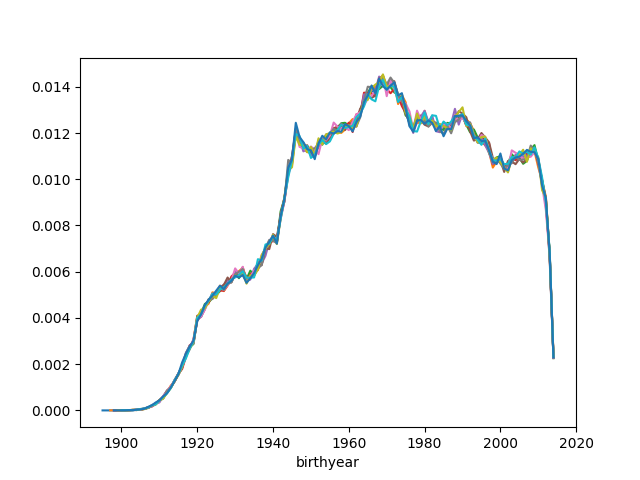

In [31]:
%%python
plt.clf()
#ax = figure
ax = df.plot(x="birthyear",y="count")
i=0
#plot multiple figures onto the same axis
while i<10:
    sample = sample_from_patients(1/10)
    sample.plot(x="birthyear", y="count", ax=ax)
    i+=1

ax.legend_.remove()
retval = plotfig_magic()

## Plot the distribution of prescriptions by age

In [32]:
//val id_with_birthyear = patients.select("id", "birthyear")
spark.sql("select pre.id, pat.birthyear from prescriptions pre, patients pat where pre.id = pat.id")
    .groupBy("birthyear")
    .count.sort("birthyear").createOrReplaceTempView("prescription_counts_by_birthyear")


In [33]:
%%python
pres_c_year = spark.sql("select * from prescription_counts_by_birthyear").toPandas()


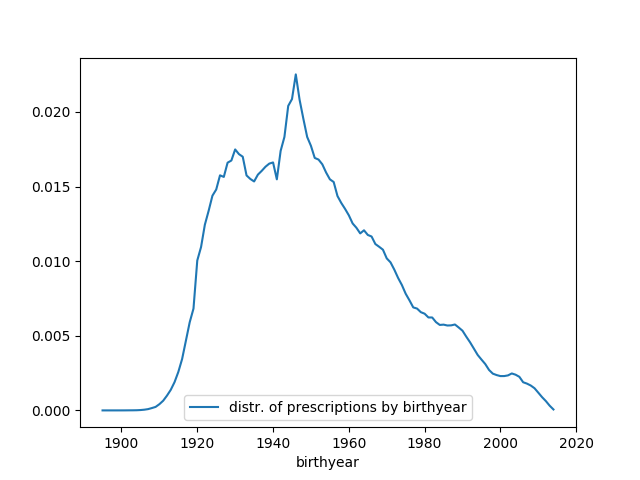

In [34]:
%%python
plt.clf()
pres_c_year["count"] = pres_c_year["count"]/pres_c_year["count"].sum()
prescription_counts_pdf = pres_c_year

ax = pres_c_year.plot(x="birthyear", y="count", label="distr. of prescriptions by birthyear")
retval = plotfig_magic()

### Now that we've normalized the distributions, we can apply them on top of each other
#### Observe the differences

1.0000000000000002
1.0


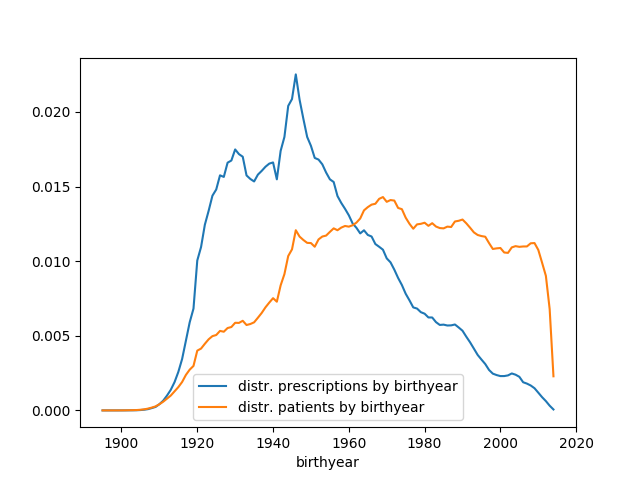

In [35]:
%%python
plt.clf()
#plot prescriptions
ax = pres_c_year.plot(x="birthyear", y="count", label="distr. prescriptions by birthyear")
#plot distribution of people
print(df["count"].sum())
print(pres_c_year["count"].sum())

df.plot(x="birthyear",y="count", label="distr. patients by birthyear", ax=ax)
retval = plotfig_magic()

In [36]:
spark.sql("show tables").show

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |     birthyearcounts|       true|
|        |               drugs|       true|
|        |              elders|       true|
|        |        elders_drugs|       true|
|        |     elders_patients|       true|
|        |elders_prescriptions|       true|
|        |          npr_elders|       true|
|        |            patients|       true|
|        |prescription_coun...|       true|
|        |  prescription_drugs|       true|
|        |prescription_pati...|       true|
|        |prescription_pres...|       true|
|        |       prescriptions|       true|
+--------+--------------------+-----------+

